# Microphysical Processes Investigation
I am trying to simplify the variables that I am looking at in order to better understand the microphysics of the model.

## Gameplan:

### Variables:
Ice crystal size (AREI / FREQI)  
Cloud ice number (NUMICE)  
Mixed-phase cloud Cloud ice number (NUMICE10s)  

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38201")
client

OSError: Timed out trying to connect to 'tcp://127.0.0.1:38201' after 10 s: Timed out trying to connect to 'tcp://127.0.0.1:38201' after 10 s: in <distributed.comm.tcp.TCPConnector object at 0x7f69579bc400>: ConnectionRefusedError: [Errno 111] Connection refused

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
mods_dir = 'inp_validation/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(mods_dir) and os.path.exists(output_dir) and os.path.exists(mods_dir)
print('Can access all directory paths:', access_paths)

Running on storm.uio.no, attempting to mount ns9600k/jonahks/ from NIRD
Can access all directory paths: True


In [3]:
#all_cases = os.listdir('/home/jonahks/drivemount/mnth15runs/')
all_cases = os.listdir(case_dir)

all_cases

['20200112_002538_singleparam_nudge_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_10_inp_1',
 '20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 'error_vs_iso.png',
 '.ipynb_checkpoints',
 'unused',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 'runs_as_vectors.png',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20200109_1541_wbf_1.0_inp_1.0',
 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
 'para

In [4]:
cases = ['20200109_1541_wbf_1.0_inp_1.0', 
         '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
         '20200112_002538_singleparam_nudge_wbf_1_inp_0',
         '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
         '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
         '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
         '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
         '20200116_130416_nudged_wbfmods_wbf_10_inp_1']

inp_mods_only = ['20200109_1541_wbf_1.0_inp_1.0', 
                 '20200112_002538_singleparam_nudge_wbf_1_inp_0',
                 '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
                 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
                 '20200110_142006_singleparam_nudge_wbf_1_inp_1000']

wbf_mods_only = ['20200109_1541_wbf_1.0_inp_1.0',
                 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
                 '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
                 '20200116_130416_nudged_wbfmods_wbf_10_inp_1']

best_mods = ['20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
         '20200204_113441_singleparam_inpcheck_wbf_1_inp_10']

In [5]:
variables = ['AREI','FREQI','NUMICE','NUMICE10s']

## Load Model Output using XArray

In [6]:
xr.set_options(keep_attrs=True)  # keeps variable names and units

# Load NorESM data
processed = []
names = []
for i in cases:
    ds = xr.open_mfdataset('%s/%s/%s.nc' % (case_dir, i, i), combine='by_coords', chunks={'lat':10})
    _nm = ' '.join(i.split('_')[-5:])
    
    if (len(ds['time']) > 1):
        try:
            ds = ds.sel(time=slice('0001-04-01', '0002-03-01'))
        except:
            ds = ds.sel(time=slice('2000-04-01', '2001-03-01'))
    ds = add_weights(ds) # still has time here
    
    ds['NUMICE10s_kg'] = ds['NUMICE10s']/ds['RHO_CLUBB']
    ds['NUMICE10s_kg'].attrs['units']='#/kg'    
    ds['ICERADIUS'] = ds['AREI']/ds['FREQI']
    ds['DROPLETRADIUS'] = ds['AREL']/ds['FREQL']
    processed.append(ds)
    
    variables.append('NUMICE10s_kg'); variables.append('ICERADIUS'); 
    
    names.append(_nm)        

## Plot AREI/FREQI

/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/dask/array/nu

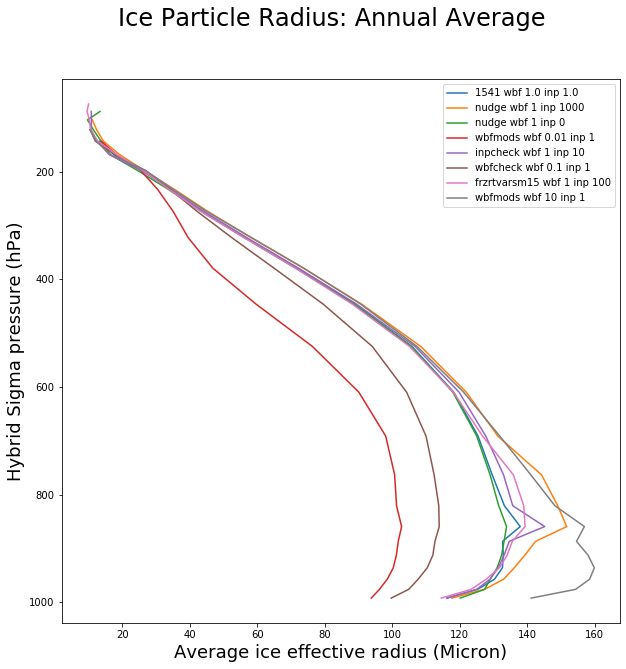

In [33]:
test_plot = plt.figure(figsize=[10,10])
#colors = ['green','red','blue','pink','orange',]
arc_mask= np.bitwise_or(ds['lat']<70, ds['lat']>90)
weight = ds['cell_weight']
    
test_plot.gca().invert_yaxis()
#for (ds, nm, color) in zip(processed, names, colors):
for (ds, nm) in zip(processed, names):
    working_da = ds['ICERADIUS'].sel(lat=slice(70,90)) # select variable and lat range
    working_da = working_da.mean(dim='time') # select time or average by it
    avg_var = masked_average(working_da, dim=['lat','lon'],weights=weight) # finally actually compute on the bounded variable of interest
#    print(avg_var.values)
    plt.plot(avg_var, avg_var['lev'], label=nm)#, color=color)
    
variable_name = "%s (%s)" % (avg_var.long_name, avg_var.units)
#    avg_rad.to_array()
    
#feb_plot.legend(loc='upper right')
plt.legend(loc='upper right')
test_plot.suptitle('Ice Particle Radius: Annual Average', fontsize=24)
plt.xlabel(variable_name, fontsize=18); plt.ylabel('Hybrid Sigma pressure (hPa)', fontsize=18);

Here, we see immediately the effect of the WBF process on the effective ice radius. Reducing the efficiency of the WBF process slows the growth of ice crystals, reducing their size.  
A factor of 100x reduction in the WBF process reduces the effective ice radius significantly across all isotherms. A 10x reduction has a similar effect, though less pronounced.  Alternately, a 10x increase in WBF efficiency increases the effective ice radius, but only at the lower isobars (P > 600 hPa).

The INP effect is less pronounced, and appears to be more isobar dependent.  
Removing INPs entirely seems to have almost no impact on the effective radius, most confusingly. Increases in the INP concentration cause only moderate increases in the average effective radius. This is at first confusing, as we might expect an increase in INPs to reduce the average radius by allowing nucleation to occur at more sites. Given how I modify the model, however, I believe that only the nucleation rates are being changed. This certainly warrants more investigation.

Generally, it may be important to observe the reductions in the ice crystal size occur over almost all pressure levels, while increases occur only below 600 hPa. This might imply some other limiting factor within the model.

## Plot AREL/FREQL

/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/jonahks/anaconda3/envs/esm-python-analysis/lib/python3.7/site-packages/dask/array/nu

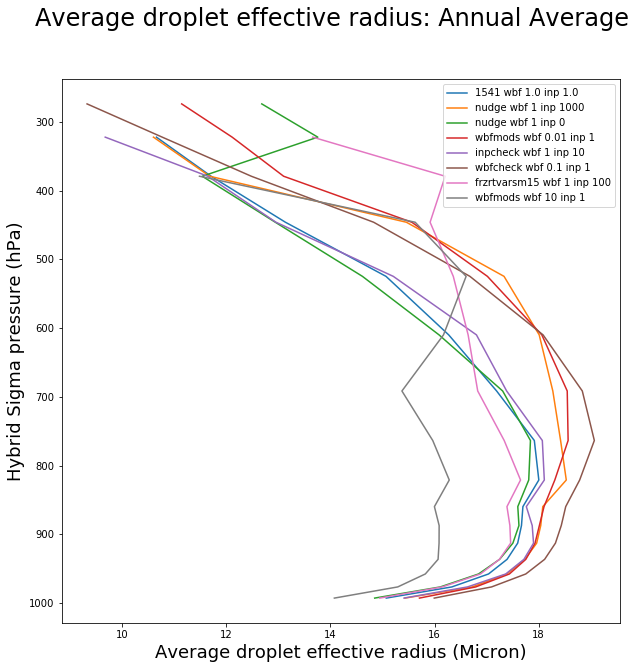

In [62]:
test_plot = plt.figure(figsize=[10,10])
#colors = ['green','red','blue','pink','orange',]
arc_mask= np.bitwise_or(ds['lat']<70, ds['lat']>90)
weight = ds['cell_weight']
    
test_plot.gca().invert_yaxis()
#for (ds, nm, color) in zip(processed, names, colors):
for (ds, nm) in zip(processed, names):
    working_da = ds['DROPLETRADIUS'].sel(lat=slice(70,90)) # select variable and lat range
    working_da = working_da.mean(dim='time') # select time or average by it
    avg_var = masked_average(working_da, dim=['lat','lon'],weights=weight) # finally actually compute on the bounded variable of interest
#    print(avg_var.values)
    plt.plot(avg_var, avg_var['lev'], label=nm)#, color=color)
    
variable_name = "%s (%s)" % (avg_var.long_name, avg_var.units)
#    avg_rad.to_array()
    
#feb_plot.legend(loc='upper right')
plt.legend(loc='upper right')
test_plot.suptitle('%s: Annual Average' % avg_var.long_name, fontsize=24)
plt.xlabel(variable_name, fontsize=18); plt.ylabel('Hybrid Sigma pressure (hPa)', fontsize=18);

As one might expect, changes in the radius of cloud ice particles are accompanied by an opposite change in the water droplet size. 

For the WBF process, increases in ice crystal size come at the expense of liquid droplets, which shrink in size. Reductions in the WBF efficiency allow droplets to grow larger. Somewhat surprisingly, however, the largest droplet sizes are achieved with the 10x WBF reduction rather than the 100x WBF reduction.

For INP modifications, the effect is unclear. Removing INPs causes almost no change in droplet size. Increases in INP concentration have inconsistent effects on the droplet size across pressure levels and between model runs.

## Plot AWNI

(0, 30000.0)

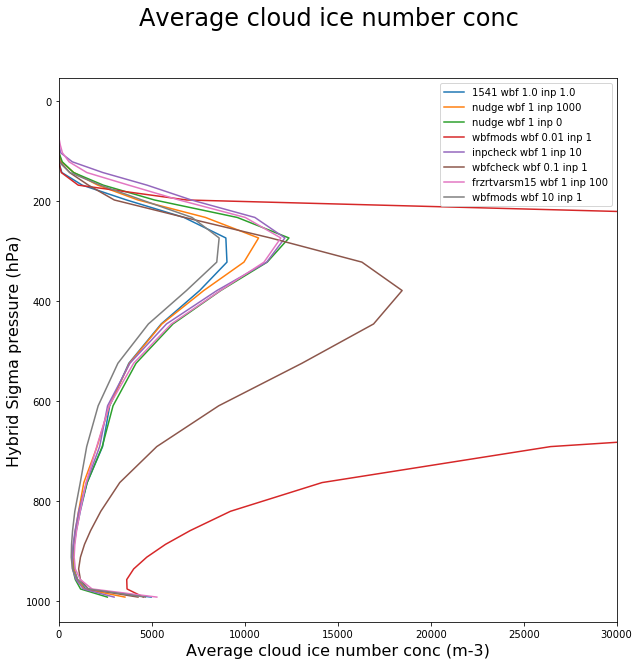

In [63]:
test_plot = plt.figure(figsize=[10,10])

arc_mask= np.bitwise_or(ds['lat']<70, ds['lat']>90)
weight = ds['cell_weight']
    
test_plot.gca().invert_yaxis()
for (ds, nm) in zip(processed, names):
    working_da = ds['AWNI'].sel(lat=slice(70,90)) # select variable and lat range
    working_da = working_da.mean(dim='time') # select time or average by it
    avg_var = masked_average(working_da, dim=['lat','lon'],weights=weight) # finally actually compute on the bounded variable of interest
    plt.plot(avg_var, avg_var['lev'], label=nm)#, color=color)
    
#    avg_var = masked_average(ds['AWNI'], dim=['lat','lon','time'],weights=weight, mask=arc_mask)
#    plt.plot(avg_var, avg_var['lev'], label=nm)
    
variable_name = "%s (%s)" % (avg_var.long_name, avg_var.units)
    
plt.legend(loc='upper right')
test_plot.suptitle(avg_var.long_name, fontsize=24)
plt.xlabel(variable_name, fontsize=16); plt.ylabel('Hybrid Sigma pressure (hPa)', fontsize=16);

plt.xlim((0,3e4))

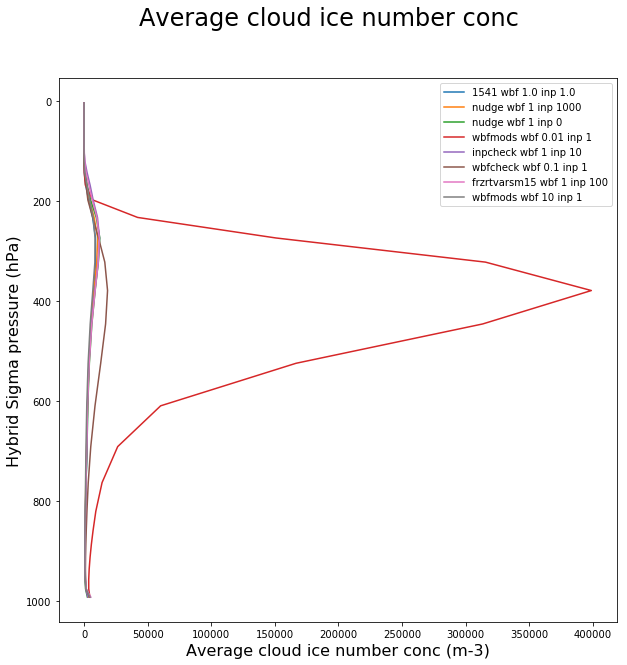

In [13]:
test_plot = plt.figure(figsize=[10,10])

arc_mask= np.bitwise_or(ds['lat']<70, ds['lat']>90)
weight = ds['cell_weight']
    
test_plot.gca().invert_yaxis()
for (ds, nm) in zip(processed, names):
    working_da = ds['AWNI'].sel(lat=slice(70,90)) # select variable and lat range
    working_da = working_da.mean(dim='time') # select time or average by it
    avg_var = masked_average(working_da, dim=['lat','lon'],weights=weight) # finally actually compute on the bounded variable of interest
    plt.plot(avg_var, avg_var['lev'], label=nm)#, color=color)
    
#    avg_var = masked_average(ds['AWNI'], dim=['lat','lon','time'],weights=weight, mask=arc_mask)
    
#    plt.plot(avg_var, avg_var['lev'], label=nm)
    
variable_name = "%s (%s)" % (avg_var.long_name, avg_var.units)
#    avg_rad.to_array()
    
#feb_plot.legend(loc='upper right')
plt.legend(loc='upper right')
test_plot.suptitle(avg_var.long_name, fontsize=24)
plt.xlabel(variable_name, fontsize=16); plt.ylabel('Hybrid Sigma pressure (hPa)', fontsize=16);

Perhaps the most confusing/useful result.  
Increasing the WBF efficiency lowers the average ice concentration across all isobars, perhaps due to increased fallout. Slowing the WBF process increases the average cloud ice number significantly, and shifts the peak concentration downwards from ~300 hPa to ~400 hPa. A strange effect is apparent here, as a 100x reduction in WBF efficiency causes the ice number concentration to have a ~40x increase.

On the INP side, results of microphysics changes are also unclear. Ice concentration increases with INP multipliers of 10x, 100x, and 0x are nearly identical. A 1000x INP increase raises ice concentrations only slightly.

## NUMICE

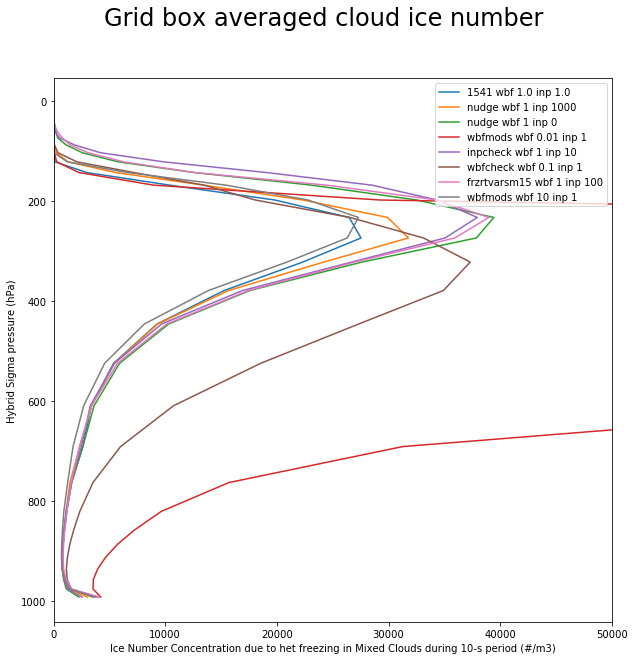

In [79]:
test_plot = plt.figure(figsize=[10,10])

arc_mask= np.bitwise_or(ds['lat']<70, ds['lat']>90)
weight = ds['cell_weight']
    
test_plot.gca().invert_yaxis()
for (ds, nm) in zip(processed, names):
    working_da = ds['NUMICE'].sel(lat=slice(70,90)) # select variable and lat range
    working_da = working_da.mean(dim='time') # select time or average by it
    avg_var = masked_average(working_da, dim=['lat','lon'],weights=weight) # finally actually compute on the bounded variable of interest
#    print(avg_var.values)
    plt.plot(avg_var, avg_var['lev'], label=nm)#, color=color)

#    avg_rad = masked_average(ds['NUMICE10s_kg'], dim=['lat','lon','time'],weights=weight, mask=arc_mask)
        
#    plt.plot(avg_rad, avg_rad['lev'], label=nm)
    
xaxis_label = '%s (%s)' % (avg_rad.long_name, avg_rad.units)
    
plt.xlim((0,5e4))
#feb_plot.legend(loc='upper right')
plt.legend(loc='upper right')
test_plot.suptitle(avg_var.long_name, fontsize=24)
plt.xlabel(xaxis_label); plt.ylabel('Hybrid Sigma pressure (hPa)');

This is a similar result to AWNI, but the ice number increase with WBF reduced 10x is less than in AWNI. I don't understand why, but it doesn't make a huge difference.

## NUMICE10s_kg

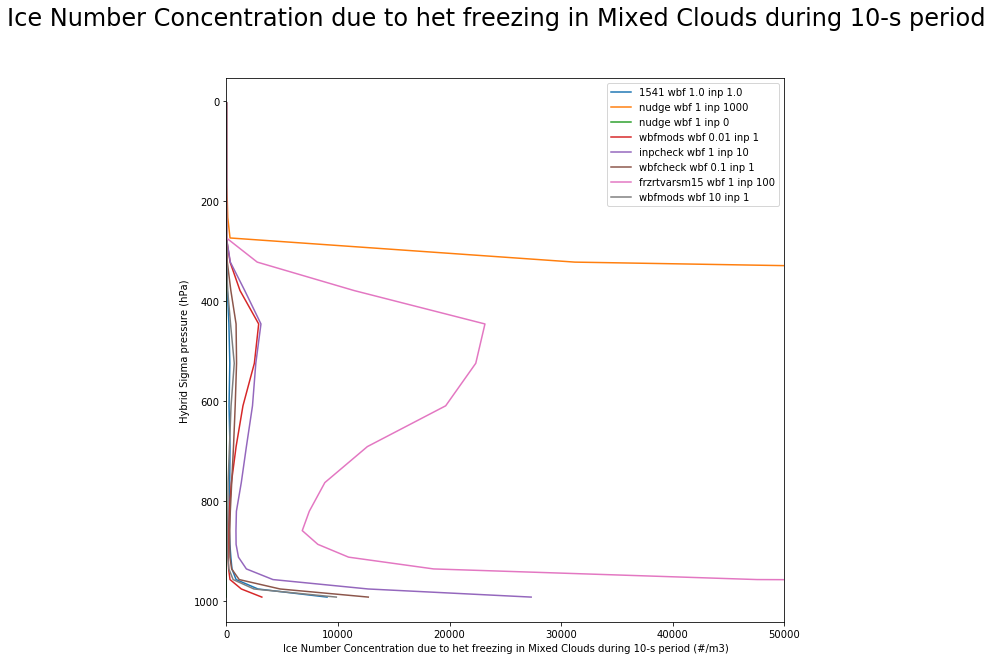

In [73]:
test_plot = plt.figure(figsize=[10,10])

arc_mask= np.bitwise_or(ds['lat']<70, ds['lat']>90)
weight = ds['cell_weight']
    
test_plot.gca().invert_yaxis()
for (ds, nm) in zip(processed, names):
    working_da = ds['NUMICE10s_kg'].sel(lat=slice(70,90)) # select variable and lat range
    working_da = working_da.mean(dim='time') # select time or average by it
    avg_var = masked_average(working_da, dim=['lat','lon','ilev'],weights=weight) # finally actually compute on the bounded variable of interest
#    print(avg_var.values)
    plt.plot(avg_var, avg_var['lev'], label=nm)#, color=color)

#    avg_rad = masked_average(ds['NUMICE10s_kg'], dim=['lat','lon','time'],weights=weight, mask=arc_mask)
        
#    plt.plot(avg_rad, avg_rad['lev'], label=nm)
    
xaxis_label = '%s (%s)' % (avg_rad.long_name, avg_rad.units)
    
plt.xlim((0,5e4))
#feb_plot.legend(loc='upper right')
plt.legend(loc='upper right')
test_plot.suptitle(avg_var.long_name, fontsize=24)
plt.xlabel(xaxis_label); plt.ylabel('Hybrid Sigma pressure (hPa)');

The result from this diagnostic variable shows the disconnect between the hetfrz_classnuc program and the general NUMICE variable. More aerosols here causes a huge increase in the ice concentration freezing rate, but their is no corresponding change in the NUMICE variable (below).

## Plot AWNC

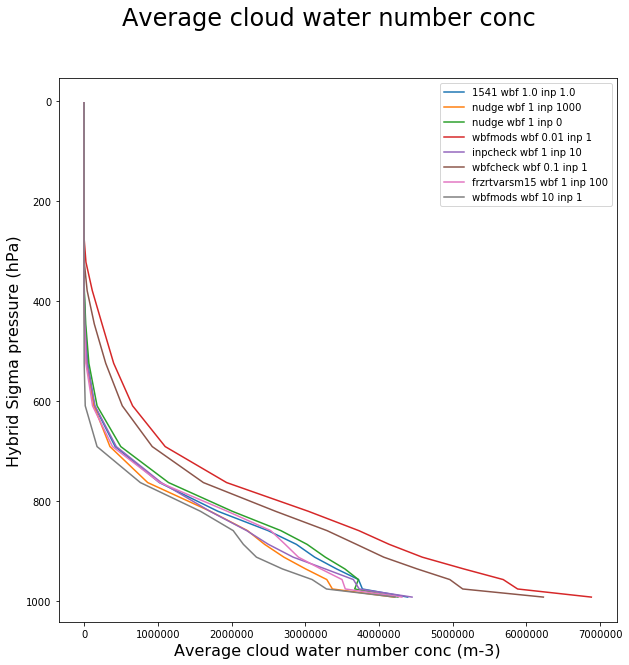

In [84]:
test_plot = plt.figure(figsize=[10,10])

arc_mask= np.bitwise_or(ds['lat']<70, ds['lat']>90)
weight = ds['cell_weight']
    
test_plot.gca().invert_yaxis()
for (ds, nm) in zip(processed, names):
    
    working_da = ds['AWNC'].sel(lat=slice(70,90)) # select variable and lat range
    working_da = working_da.mean(dim='time') # select time or average by it
    avg_var = masked_average(working_da, dim=['lat','lon'],weights=weight) # finally actually compute on the bounded variable of interest
    plt.plot(avg_var, avg_var['lev'], label=nm)#, color=color)
    
variable_name = "%s (%s)" % (avg_var.long_name, avg_var.units)
#    avg_rad.to_array()
    
#feb_plot.legend(loc='upper right')
plt.legend(loc='upper right')
test_plot.suptitle(avg_var.long_name, fontsize=24)
plt.xlabel(variable_name, fontsize=16); plt.ylabel('Hybrid Sigma pressure (hPa)', fontsize=16);